<a href="https://colab.research.google.com/github/8Dis-like/UCLALearning/blob/main/FC_nets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fully connected networks

In the previous notebook, you implemented a simple two-layer neural network class.  However, this class is not modular.  If you wanted to change the number of layers, you would need to write a new loss and gradient function.  If you wanted to optimize the network with different optimizers, you'd need to write new training functions.  If you wanted to incorporate regularizations, you'd have to modify the loss and gradient function.  

Instead of having to modify functions each time, for the rest of the class, we'll work in a more modular framework where we define forward and backward layers that calculate losses and gradients respectively.  Since the forward and backward layers share intermediate values that are useful for calculating both the loss and the gradient, we'll also have these function return "caches" which store useful intermediate values.

The goal is that through this modular design, we can build different sized neural networks for various applications.

In this HW #3, we'll define the basic architecture, and in HW #4, we'll build on this framework to implement different optimizers and regularizations (like BatchNorm and Dropout).

CS231n has built a solid API for building these modular frameworks and training them, and we will use their very well implemented framework as opposed to "reinventing the wheel."  This includes using their Solver, various utility functions, and their layer structure.  This also includes nndl.fc_net, nndl.layers, and nndl.layer_utils.  As in prior assignments, we thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  

## Modular layers

This notebook will build modular layers in the following manner.  First, there will be a forward pass for a given layer with inputs (`x`) and return the output of that layer (`out`) as well as cached variables (`cache`) that will be used to calculate the gradient in the backward pass.

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive derivative of loss with respect to outputs and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

In [ ]:
## Import and setups

import time
import numpy as np
import matplotlib.pyplot as plt
from nndl.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k in data.keys():
  print('{}: {} '.format(k, data[k].shape))

X_train: (49000, 3, 32, 32) 
y_train: (49000,) 
X_val: (1000, 3, 32, 32) 
y_val: (1000,) 
X_test: (1000, 3, 32, 32) 
y_test: (1000,) 


## Linear layers

In this section, we'll implement the forward and backward pass for the linear layers.

The linear layer forward pass is the function `affine_forward` in `nndl/layers.py` and the backward pass is `affine_backward`.

After you have implemented these, test your implementation by running the cell below.

### Affine layer forward pass

Implement `affine_forward` and then test your code by running the following cell.

In [ ]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around 1e-9.
print('Testing affine_forward function:')
print('difference: {}'.format(rel_error(out, correct_out)))

Testing affine_forward function:
difference: 9.769849468192957e-10


### Affine layer backward pass

Implement `affine_backward` and then test your code by running the following cell.

In [ ]:
# Test the affine_backward function

x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around 1e-10
print('Testing affine_backward function:')
print('dx error: {}'.format(rel_error(dx_num, dx)))
print('dw error: {}'.format(rel_error(dw_num, dw)))
print('db error: {}'.format(rel_error(db_num, db)))

Testing affine_backward function:
dx error: 5.0304338658412205e-09
dw error: 3.3786027041256256e-10
db error: 3.2766516476600243e-12


## Activation layers

In this section you'll implement the ReLU activation.

### ReLU forward pass

Implement the `relu_forward` function in `nndl/layers.py` and then test your code by running the following cell.

In [ ]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be around 1e-8
print('Testing relu_forward function:')
print('difference: {}'.format(rel_error(out, correct_out)))

Testing relu_forward function:
difference: 4.999999798022158e-08


### ReLU backward pass
Implement the `relu_backward` function in `nndl/layers.py` and then test your code by running the following cell.

In [ ]:
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be around 1e-12
print('Testing relu_backward function:')
print('dx error: {}'.format(rel_error(dx_num, dx)))

Testing relu_backward function:
dx error: 3.2755982712853154e-12


## Combining the affine and ReLU layers

Often times, an affine layer will be followed by a ReLU layer. So let's make one that puts them together.  Layers that are combined are stored in `nndl/layer_utils.py`.  

### Affine-ReLU layers
We've implemented `affine_relu_forward()` and `affine_relu_backward` in ``nndl/layer_utils.py``.  Take a look at them to make sure you understand what's going on.  Then run the following cell to ensure its implemented correctly.

In [ ]:
from nndl.layer_utils import affine_relu_forward, affine_relu_backward

x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: {}'.format(rel_error(dx_num, dx)))
print('dw error: {}'.format(rel_error(dw_num, dw)))
print('db error: {}'.format(rel_error(db_num, db)))

Testing affine_relu_forward and affine_relu_backward:
dx error: 5.078537698879339e-11
dw error: 2.189944703618186e-09
db error: 6.880175915883598e-12


## Softmax and SVM losses

You've already implemented these, so we have written these in `layers.py`.  The following code will ensure they are working correctly.

In [ ]:
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be 1e-9
print('Testing svm_loss:')
print('loss: {}'.format(loss))
print('dx error: {}'.format(rel_error(dx_num, dx)))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be 2.3 and dx error should be 1e-8
print('\nTesting softmax_loss:')
print('loss: {}'.format(loss))
print('dx error: {}'.format(rel_error(dx_num, dx)))

Testing svm_loss:
loss: 9.000133705498998
dx error: 8.182894472887002e-10

Testing softmax_loss:
loss: 2.302598890306366
dx error: 7.938863722250494e-09


## Implementation of a two-layer NN

In `nndl/fc_net.py`, implement the class `TwoLayerNet` which uses the layers you made here.  When you have finished, the following cell will test your implementation.

In [ ]:
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-2
model = TwoLayerNet(input_dim=D, hidden_dims=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = {}'.format(reg))
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('{} relative error: {}'.format(name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg = 0.0
W1 relative error: 1.8336562786695002e-08
W2 relative error: 3.201560569143183e-10
b1 relative error: 9.828315204644842e-09
b2 relative error: 4.329134954569865e-10
Running numeric gradient check with reg = 0.7
W1 relative error: 2.5279152310200606e-07
W2 relative error: 7.976652806155026e-08
b1 relative error: 1.564679947504764e-08
b2 relative error: 9.089617896905665e-10


## Solver

We will now use the cs231n Solver class to train these networks.  Familiarize yourself with the API in `cs231n/solver.py`.  After you have done so, declare an instance of a TwoLayerNet with 200 units and then train it with the Solver.  Choose parameters so that your validation accuracy is at least 40%.

In [ ]:
model = TwoLayerNet()
solver = None

# ================================================================ #
# YOUR CODE HERE:
#   Declare an instance of a TwoLayerNet and then train
#   it with the Solver. Choose hyperparameters so that your validation
#   accuracy is at least 40%.  We won't have you optimize this further
#   since you did it in the previous notebook.
#
# ================================================================ #

pass

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #

In [ ]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

## Multilayer Neural Network

Now, we implement a multi-layer neural network.

Read through the `FullyConnectedNet` class in the file `nndl/fc_net.py`.

Implement the initialization, the forward pass, and the backward pass.  There will be lines for batchnorm and dropout layers and caches; ignore these all for now.  That'll be in assignment #4.

In [ ]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print('Running check with reg = {}'.format(reg))
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print('Initial loss: {}'.format(loss))

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('{} relative error: {}'.format(name, rel_error(grad_num, grads[name])))

Running check with reg = 0
Initial loss: 2.304146153180416
W1 relative error: 2.6801358244466505e-06
W2 relative error: 1.374956462320052e-06
W3 relative error: 8.417665745014667e-08
b1 relative error: 1.2085842991163667e-08
b2 relative error: 2.4058024882489714e-08
b3 relative error: 6.832746086246097e-11
Running check with reg = 3.14
Initial loss: 6.967494883062306
W1 relative error: 7.294088428691085e-09
W2 relative error: 3.836274335648032e-08
W3 relative error: 1.8812532473286155e-08
b1 relative error: 2.0170370768147783e-07
b2 relative error: 8.379107094662078e-08
b3 relative error: 3.7618771892752947e-10


(Iteration 1 / 40) loss: 2.345440
(Epoch 0 / 20) train acc: 0.020000; val_acc: 0.100000
(Epoch 1 / 20) train acc: 0.020000; val_acc: 0.100000
(Epoch 2 / 20) train acc: 0.020000; val_acc: 0.101000
(Epoch 3 / 20) train acc: 0.020000; val_acc: 0.101000
(Epoch 4 / 20) train acc: 0.020000; val_acc: 0.100000
(Epoch 5 / 20) train acc: 0.020000; val_acc: 0.099000
(Iteration 11 / 40) loss: 2.339104
(Epoch 6 / 20) train acc: 0.020000; val_acc: 0.099000
(Epoch 7 / 20) train acc: 0.020000; val_acc: 0.097000
(Epoch 8 / 20) train acc: 0.020000; val_acc: 0.097000
(Epoch 9 / 20) train acc: 0.020000; val_acc: 0.097000
(Epoch 10 / 20) train acc: 0.040000; val_acc: 0.097000
(Iteration 21 / 40) loss: 2.285994
(Epoch 11 / 20) train acc: 0.040000; val_acc: 0.098000
(Epoch 12 / 20) train acc: 0.080000; val_acc: 0.098000
(Epoch 13 / 20) train acc: 0.080000; val_acc: 0.096000
(Epoch 14 / 20) train acc: 0.080000; val_acc: 0.098000
(Epoch 15 / 20) train acc: 0.080000; val_acc: 0.099000
(Iteration 31 / 40) loss: 

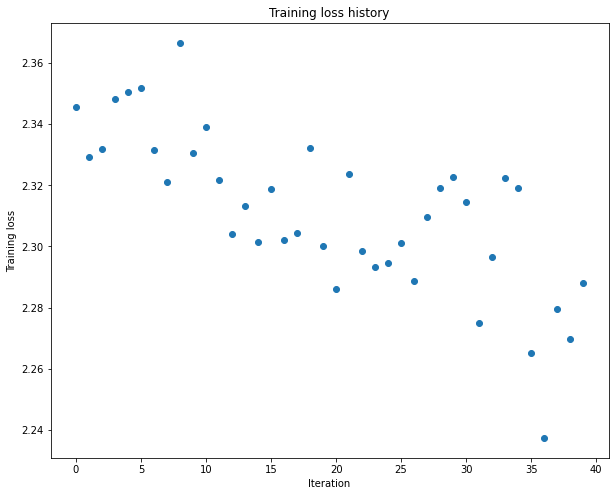

In [ ]:
# Use the three layer neural network to overfit a small dataset.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}


#### !!!!!!
# Play around with the weight_scale and learning_rate so that you can overfit a small dataset.
# Your training accuracy should be 1.0 to receive full credit on this part.
weight_scale = 1e-2
learning_rate = 1e-4

model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()